In [86]:
import numpy as np
%matplotlib inline
from pylab import *
from numpy import linalg
import math
import cProfile
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 12]
font = {'family' : 'sans-serif', 'size' : 22}
matplotlib.rc('font', **font)

Visit my github, https://github.com/gary-dalton/math793

# Code Companion to Math 793: Cramer's Rule

The intent of this notebook is to serve as a code companion, examples, library, and exploratory for the main document, _Math 793: Cramer's Rule_ which is available as a PDF from the github listed above. There may be some duplication between the documents for explanatory purposes.

# Test Matrices

## Import Matrix Market format

In [2]:
from scipy import io
print(io.mminfo('rbs480a.mtx'))
a = io.mmread('rbs480a.mtx')
A=  a.todense()

(480, 480, 17088, 'coordinate', 'real', 'general')


## Generate Matrix

However, many test matrices are generated. Often, these were generated using The Matrix Computation Toolkit for Matlab. A very useful python package to generate a variety of test matrices is in Scipy.sparse. See the code example:

In [3]:
# DOCUMENTATION: https://docs.scipy.org/doc/scipy/reference/sparse.html
# https://docs.scipy.org/doc/scipy/reference/stats.html
import scipy.sparse as sparse
import scipy.stats as stats

In [4]:
# sets reproducibility
np.random.seed(5) 
# Poisson
rvs = stats.poisson(18, loc=10).rvs
# generate sparse 5x5 random matrix with density 0.75
A = sparse.random(5, 5, density=0.75, data_rvs=rvs)
rvs = stats.norm(loc=10, scale=20).rvs
# create sparse 3x3 matrix with density 0.5
B = sparse.random(3, 3, density=0.75, data_rvs=rvs)
A = A.toarray()
B = B.todense()
A, B

(array([[20., 29., 29.,  0., 29.],
        [23.,  0., 26.,  0., 30.],
        [28., 30., 30., 29., 31.],
        [ 0., 23., 25., 34., 25.],
        [29.,  0.,  0., 24., 26.]]),
 matrix([[ 1.28592162,  0.        , 12.49613651],
         [29.44358619,  5.18577715,  0.        ],
         [23.13238941, 55.20213547,  7.8567203 ]]))

Is there a difference in using either of these forms, matrix or array? I think that either will work fine but numpy is most suitable for working with arrays for slicing and dicing. So mostly, this work will use the array form of the matrix.

In [5]:
""" Return a matrix with a maximal growth factor in Gaussian elimination with partial pivoting.
    Reference:
       N. J. Higham and D. J. Higham, Large growth factors in
         Gaussian elimination with pivoting, SIAM J. Matrix Analysis and
         Appl., 10 (1989), pp. 155-164.
"""
def gfpp(n):
    L = np.eye(n) - np.tril(np.ones(n) , -1)
    L[:, n-1:] = np.ones((n, 1))
    return L

# Solve a linear system by Cramer's formula
Consider the **linear systems** in the matrix form $Ax = b$

## A Function for Cramer's rule

In [6]:
def cramer_solve(A, b):
    """Solve a system of linear equations using Cramer's Rule and LU Decomposition.
    Returns the solution vector."""
    
    # LU Decomposition
    p,l,u = sla.lu(A)
    DA = sla.det(p)*sla.det(u)
    if DA ==0:
        raise ZeroDivisionError('The input matrix is Singular')
    
    # Solution storage
    x = np.zeros((n,1))
    x.astype(double)
    
    # Loop to find each solution
    for i in range(len(b)):
        Ai = np.copy(A)
        Ai[:,i] = b[:,0]
        p,l,u = sla.lu(Ai)
        DAi = sla.det(p)*sla.det(u)
        x[i] = DAi / DA
    return x

### Using cramer_solve

In [7]:
# Set up a run and create test matrices
import scipy.sparse as sparse
import scipy.stats as stats
import scipy.linalg as sla

I have found using density values above about 0.5 reduces the number of singular matrices generated. There are singular matrix checks in the code but it better to avoid generating them in the first place. Using random dense matrices does not really permit this check.

In [8]:
# Create test matrices
# Enter a value of n
n=150
# Sets reproducibility
np.random.seed(5) 
# Use Poisson
rvs = stats.poisson(18, loc=10).rvs
# Generate test matrices A and b
A = sparse.random(n, n, density=0.5, data_rvs=rvs).toarray()
b = sparse.random(n, 1, density=0.5, data_rvs=rvs).toarray()

# Check rank of matrix for sungularity
if linalg.matrix_rank(A) != n:
    print("NOTE: Matrix is singular, create a different matrix to continue")

In [9]:
# OPTIONAL
# Use gfpp matrix instead
A = gfpp(n)

In [10]:
def compare_err(A, b):
    if linalg.matrix_rank(A) != n:
        print("NOTE: Matrix is singular, create a different matrix to continue")
        return

    # cramer_solve
    x = cramer_solve(A,b)

    # numpy solve
    y=linalg.solve(A,b)

    print("Approximate error compared to built-in solver")
    print('L-1 norm: %.4e' % linalg.norm((x-y), 1))
    print('L-2 norm: %.4e' % linalg.norm((x-y)))
    print ("Approximate total absolute error compared to built-in solver")
    print(sum(abs(x-y)))

In [11]:
compare_err(A,b)

Approximate error compared to built-in solver
L-1 norm: 1.4878e+01
L-2 norm: 6.9396e+00
Approximate total absolute error compared to built-in solver
14.877731375717612


### Problems

* The determinant calculations can overflow the data type
* Some conditioning will be needed to prevent overflow
* Duplication of some calculations
* This is not an optimized algorithm
* The reported error is a significantly worse when using  a gfpp matrix

### Preventing Overflow / Underflow
Try using linalg.slogdet instead of linalg.det.
> Compute the sign and (natural) logarithm of the determinant of an array.
>
> If an array has a very small or very large determinant, then a call to det may overflow or underflow. This routine is more robust against such issues, because it computes the logarithm of the determinant rather than the determinant itself.

### Modified cramer_solve

In [12]:
def cramer_solve_slog(A, b):
    """Solve a system of linear equations using Cramer's Rule and LU Decomposition.
    Returns the solution vector."""
    
    if linalg.matrix_rank(A) != n:
        print("NOTE: Matrix is singular, create a different matrix to continue")
        return
    
    # LU Decomposition
    p,l,u = sla.lu(A)
    DA_sign, DA_logdet = gd_det(p,u)
    
    # Solution storage
    x = np.zeros((n,1))
    x.astype(double)
    
    # Loop to find each solution
    for i in range(len(b)):
        Ai = np.copy(A)
#         print(np.shape(Ai), np.shape(b))
        Ai[:,i] = b[:,0]
        p,l,u = sla.lu(Ai)
        DAi_sign, DAi_logdet = gd_det(p,u)
        x[i] = DA_sign * DAi_sign * np.exp(DAi_logdet - DA_logdet)
#         print(x[i])
    return x

def gd_det(*args):
    tsign = 1
    tlogdet= 0
    for arg in args:
        sign, logdet = linalg.slogdet(arg)
        tsign = tsign * sign
        tlogdet = tlogdet + logdet
    return tsign, tlogdet

### Let's test it

In [16]:
# Create test matrices
# Enter a value of n
n=100
# Sets reproducibility
np.random.seed(3) 
# Use Poisson
rvs = stats.poisson(18, loc=10).rvs
# Generate test matrices A and b
A = sparse.random(n, n, density=0.75, data_rvs=rvs).toarray()
b = sparse.random(n, 1, density=0.9, data_rvs=rvs).toarray()

In [14]:
# OPTIONAL
# Use gfpp matrix instead
A = gfpp(n)

In [17]:
def compare_err_slog(A, b):
#     if linalg.matrix_rank(A) != n:
#         print("NOTE: Matrix is singular, create a different matrix to continue")
#         return

    # cramer_solve
    x = cramer_solve_slog(A,b)

    # numpy solve
    y=linalg.solve(A,b)

    print("Approximate error compared to built-in solver")
    print('L-1 norm: %.4e' % linalg.norm((x-y), 1))
    print('L-2 norm: %.4e' % linalg.norm((x-y)))

In [18]:
compare_err_slog(A,b)

Approximate error compared to built-in solver
L-1 norm: 3.4668e-11
L-2 norm: 5.8142e-12


# Time to run

## Standard cramer_solve Time

In [60]:
# Solve Ax=b by Cramer formulas
# Set iterations and matrix size
i=140
a_time = zeros(i)
b_time = zeros(i)
L1= zeros(i)
L2= zeros(i)
for n in range(1, i):
    np.random.seed(n) 
    rvs = stats.poisson(18, loc=10).rvs
    A = sparse.random(n, n, density=0.75, data_rvs=rvs).toarray()
    b = sparse.random(n, 1, density=0.9, data_rvs=rvs).toarray()
    t0 = time.time()
    x = cramer_solve(A,b)
    t1 = time.time() 
    a_time[n] = (t1-t0)
    t0 = time.time()
    y = linalg.solve(A,b)
    t1 = time.time() 
    b_time[n] = (t1-t0)
    L1[n] = linalg.norm((x-y), 1)
    L2[n] = linalg.norm((x-y))
std_results = (a_time, b_time, L1, L2)

## Modified cramer_solve Time

In [74]:
# Solve Ax=b by Cramer formulas
# Set iterations and matrix size
i=500
a_time = zeros(i)
b_time = zeros(i)
L1= zeros(i)
L2= zeros(i)
for n in range(1, i):
    np.random.seed(n) 
    rvs = stats.poisson(18, loc=10).rvs
    A = sparse.random(n, n, density=0.75, data_rvs=rvs).toarray()
    b = sparse.random(n, 1, density=0.9, data_rvs=rvs).toarray()
    t0 = time.time()
    x = cramer_solve_slog(A,b)
    t1 = time.time() 
    a_time[n] = (t1-t0)
    t0 = time.time()
    y = linalg.solve(A,b)
    t1 = time.time() 
    b_time[n] = (t1-t0)
    L1[n] = linalg.norm((x-y), 1)
    L2[n] = linalg.norm((x-y))
mod_results = (a_time, b_time, L1, L2)

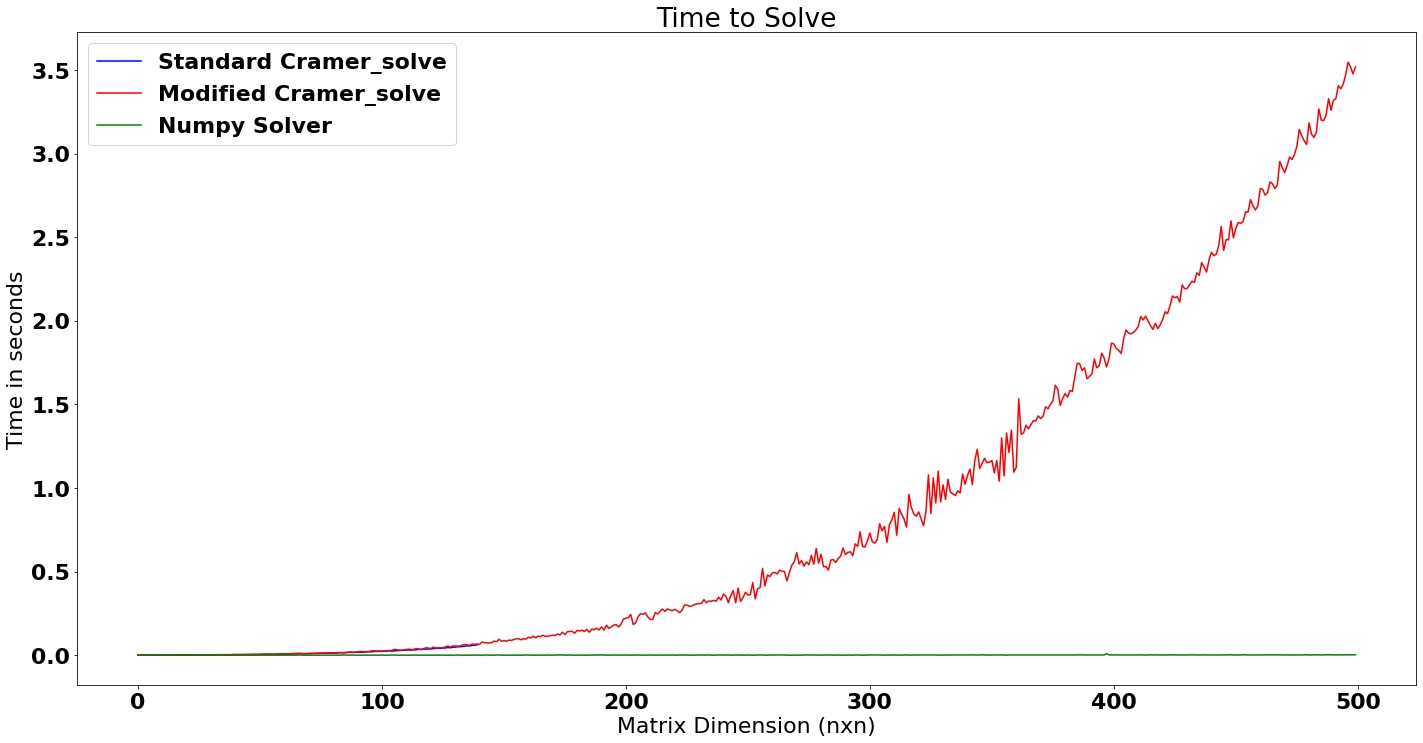

In [87]:
plt.plot(std_results[0], "-b", label="Standard Cramer_solve")
plt.plot(mod_results[0], "-r", label="Modified Cramer_solve")
plt.plot(mod_results[1], "-g", label="Numpy Solver")
plt.legend(loc="upper left")
plt.title("Time to Solve")
plt.xlabel("Matrix Dimension (nxn)")
plt.ylabel("Time in seconds")
# plt.savefig("timer.png")
plt.show()

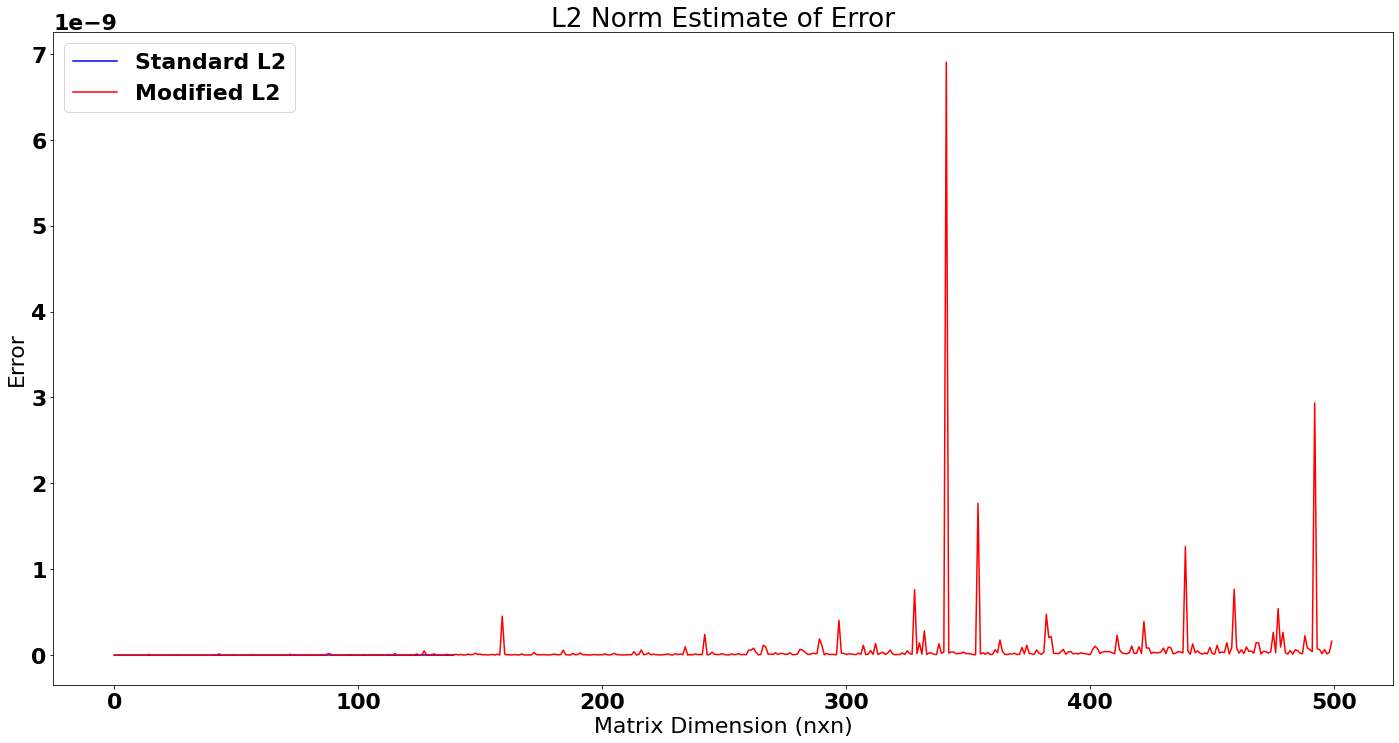

In [88]:
# plt.plot(std_results[2], "-b", label="Standard L1")
plt.plot(std_results[3], "-b", label="Standard L2")
# plt.plot(mod_results[2], "-r", label="Modified L1")
plt.plot(mod_results[3], "-r", label="Modified L2")
plt.legend(loc="upper left")
plt.title("L2 Norm Estimate of Error")
plt.xlabel("Matrix Dimension (nxn)")
plt.ylabel("Error")
# plt.savefig("error.png")
plt.show()
# plt.gca().set_aspect('equal')

# Thoughts, Opinions, and Future Directions

I hold the opinion that attempting a more efficient general system of equations solver is not a good use of time. Instead, there may be some interesting and large areas of study that involve sparse matrices or specialized solutions. Potential matrices of this type are available through _NLEVP: A Collection of Nonlinear Eigenvalue Problems_, a collection of 52 nonlinear eigenvalue problems in the form of a MATLAB toolbox. (https://github.com/ftisseur/nlevp)

Alternatively, perhaps there is some room for improvement when working with sparse matrices. I did not look closely at sparse matrices to understand the set of algorithms available to solve systems of this type. There are however a number of interesting algorithms that have developed from the bioinformatics that permit faster classification, ordering or extreme densification of data and may allow for improved results when dealing with sparse matrices.

It is also important to understand how accurate our results need to be. For some systems, dropping half of a properly ordered data set may have minimal impact on the result and would allow for use of additional decomposition methods. Some of this falls into the methods of matrix preconditioning, which is a topic for further review.

## Is Python the right approach?

I would argue that python is not really the best language for directly comparing comparing algorithm efficiency. It is fine for the general development of the algorithm but will fail at direct comparison because many of the core underlying algorithms are compiled linked objects. Any code run in the python interpreter will necessarily run slower. If any algorithms are developed, they should be further tested in a compiled language such as *Julia*

# Resources

* http://web.eecs.utk.edu/~ielhanan/Papers/JDA2011.pdf
* https://www.scirp.org/journal/paperinformation.aspx?paperid=61736
* https://www.math.utah.edu/~gustafso/determinants.pdf
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html
* https://www.netlib.org/lapack/explore-html/d7/d3b/group__double_g_esolve_ga5ee879032a8365897c3ba91e3dc8d512.html
* http://www.icl.utk.edu/~mgates3/docs/lapack.html
* https://www.netlib.org/lapack/lug/node71.html: Table 3.13
* http://www.ma.man.ac.uk/~higham/mctoolbox/
* https://people.sc.fsu.edu/~jburkardt/py_src/test_mat/test_mat.html
* https://github.com/ftisseur/nlevp
* https://www.bioinformaticsalgorithms.org/
* https://www.netlib.org/linalg/html_templates/node51.html
* https://ieeexplore.ieee.org/document/8742660
* https://www.hindawi.com/journals/isrn/2012/127647/